# Introduction to XFLR5

In [1]:
# imports
import os

import numpy
from matplotlib import pyplot
%matplotlib inline
from IPython.core.display import HTML

In [2]:
# notebook style
def css_styling():
    """Loads the style of the notebook."""
    css_path = '../../styles/custom.css'
    styles = open(css_path, 'r').read()
    return HTML(styles)
css_styling()

---

### Recap

So far, we have seen that a freestream flow can be perturbed by adding some singularities to the domain: source, sink, doublet and vortex.

Adding a [doublet](03_Lesson03_doublet.ipynb) to the freestream gives the flow around a cylinder:
![freestream_doublet](./images/freestream_doublet.png)

Adding a [vortex](06_Lesson06_vortexLift.ipynb) to the flow, we can get the streamlines around a lifting-cylinder:
![freestream_doublet_vortex](./images/freestream_doublet_vortex.png)


What happens if I increase the strength of the doublet? I get the streamlines around a cylinder with a bigger radius.
And by modifying the vortex strength, I can play with the circulation around the body.

Let's think the other way...

If the cylinder is an input (the radius and location of the center are fixed), what doublet strength will give me the streamlines around the cylinder?

---

### Panel methods

Panel method represents a class of techniques to compute the flow around any airfoil.
The geometry is discretized into segments (panels), each one of them being associated with one or more singularities.

![panel_discretization](./images/panel_discretization.png)

The location of the singularities is fixed by the shape of the airfoil. We want to obtain the strength of each singularity so that, when added to the freestream, we get the streamlines around the given airfoil.

![naca_panel_method](./images/naca_panel_method.png)

To compute the strengths, we need to form a system of equations. This is done by applying a boundary condition on each segment. For an inviscid flow, we apply a no-penetration boundary condition (the flow is tangent to the surface of the airfoil).

---

### XFoil

XFoil is a program for the design and analysis of subsonic isolated airfoils, developed by Mark Drela and Harold Youngren (MIT) in 1986. The code, implemented in FORTRAN uses panel methods to predict the polars of airfoils (2D).

In XFoil, there are three main modules:
* foil design,
* direct analysis: XFoil computes the aerodynamic properties of a given airfoil,
* inverse design: the shape of the airfoil is optimized to achieve some aerodynamic objectives.

XFoil is now embedded in XFLR5, released as an open-source software, hosted on the platform [SourceForge.net](http://sourceforge.net/projects/xflr5). The FORTRAN code was translated in C/C++, a friendly interface replaced the terminal, and three-dimensional algorithms were added to deal with finite wings and full aircrafts.

---

### Airfoil analysis using XFoil (or XFLR5)

Given the shape of the airfoil and the freestream flow conditions, XFoil performs inviscid and viscous analysis for either compressible or incompressible flows that are time-independent.

Basic panel methods lead to inviscid solutions. Thus, the viscous effects of the boundary layer and the wake must be modeled.

* The inviscid flow is solved with a panel method using a linear-vorticity stream-function formulation. 

* The viscous effects from the boundary layer and the wake are solved by adding a source to each panel (airfoil and wake). The strength of each source is related to the boundary layer quantities.

![drela_panel_method](./images/drela_panel_method.png "Discretization of the airfoil and its wake (Drela, 1986)")
<center> Discretization of the airfoil and its wake into panels (Drela, 1986) </center>

By superposing all the singularities (vortices with strength $\gamma$, sources with strength $\sigma$) to the freestream flow $(u_\infty, v_\infty)$, we get the value of the stream-function $\psi$ at a given field point $(x, y)$:

$$ \psi (x, y) = 
u_\infty y - v_\infty x 
+ \int_{\text{airfoil}} \frac{\gamma(s)}{2\pi} \ln r(s, x, y) ds 
+ \int_{\text{airfoil+wake}} \frac{\sigma(s)}{2\pi} \theta (s, x, y)  ds$$

---

### Application: NACA0012

We need to provide to XFoil, the shape of the airfoil. We choose here, the famous symmetrical NACA profile 0012.

Airfoil file format:

* The first line contains the name of the profile (e.g. NACA0012).
* x- and y- coordinates are stored in columns, starting from the trailing edge, folllowing the shape , and ending at the trailing edge again.
* Lines starting with `#` are ignored.

In [3]:
def generate_coordinates(chord=1.0, thickness=12, n=100, sharp=False):
    """Generates and returns the x- and y- coordinates 
    of the symmetrical NACA airfoil.
    
    Arguments
    ---------
    chord -- the chord length (default 1.0)
    thickness -- maximum thickness 
                 as a fraction of the chord (default 12)
    n -- number of segment to discretize the geometry (default 100)
    sharp -- sharp trailing-edge (default False)
    """
    c, t = chord, thickness/100.0
    x = numpy.linspace(0.0, c, n/2+1)
    y = 5.0*t*c*(+ 0.2969*numpy.sqrt(x/c)
                 - 0.1260*(x/c)
                 - 0.3516*(x/c)**2
                 + 0.2843*(x/c)**3
                 - (0.1036 if sharp else 0.1015)*(x/c)**4)
    return ( numpy.append(x[::-1],  x[(1 if sharp else 0)::]),
             numpy.append(y[::-1], -y[(1 if sharp else 0)::]) )

In [4]:
def write_coordinates(x, y, name='naca'):
    """Writes the x- and y- coordinates in a file.
    
    x, y -- coordinates to write
    name -- name of the output file (default naca.dat)
    """
    file_path = './airfoils/{}.dat'.format(name)
    with open(file_path, 'w') as outfile:
        outfile.write('{}\n'.format(name))
        numpy.savetxt(outfile, numpy.c_[x, y], 
                      fmt='%.6f', delimiter='\t')

In [5]:
def plot_airfoil(x, y, name='naca'):
    """Plots the NACA coordinates.
    
    Arguments
    ---------
    x, y -- coordinates of the geometry
    name -- name of the geometry (default naca)
    """
    pyplot.figure(figsize=(10, 6))
    pyplot.grid(True)
    pyplot.xlabel(r'$x$', fontsize=18)
    pyplot.ylabel(r'$y$', fontsize=18)
    pyplot.plot(x, y, label=name, color='#D95F02', 
                linestyle='-', linewidth=1, marker='o', markersize=6)
    pyplot.legend(loc='best', prop={'size': 18})
    pyplot.axis('equal')
    pyplot.savefig('./airfoils/{}.png'.format(name))

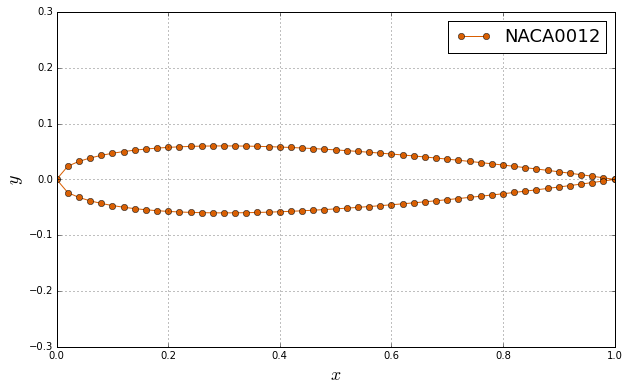

In [6]:
x, y = generate_coordinates(chord=1.0, thickness=12, n=100, sharp=True)

write_coordinates(x, y, name='NACA0012')

plot_airfoil(x, y, name='NACA0012')

---

### Comparison to wind tunnel data

Gregory and O'Reilly (1970) perfomed some experimental work on such a profile immersed in a wind tunnel. 

The Reynolds number of the flow was about $Re=2.88 \cdot 10^{6}$ and the NCA0012 profile was at small angles of attack ($\alpha= 0^o$, $10^o$ and $15^o$). 

Let's see how XFoil results compare with those data.

In [7]:
# angle of attack
alpha = 'AoA15' # choose either 'AoA0', 'AoA10' or 'AoA15'

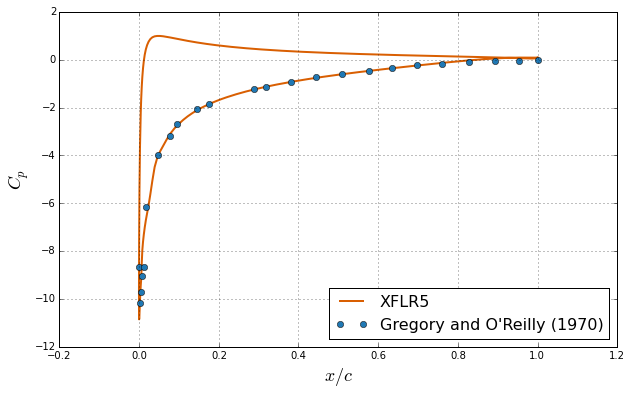

In [8]:
# surface pressure coefficient comparison: XFLR5 and Gregory and O'Reilly (1970)

# load XFLR5 pressure coeffcient data
xflr5_data = './xflr5_results/naca0012_cp_xflr5.dat'
columns = {'AoA15': (0, 1),
           'AoA10': (2, 3),
           'AoA5': (4, 5),
           'AoA0': (6, 7),}
with open(xflr5_data, 'r') as infile:
    x, cp = numpy.loadtxt(infile, dtype=float, skiprows=1, 
                          usecols=columns[alpha], unpack=True)

# load experimental pressure coefficient data
exp_data = ('./experimental_data/'
            'gregory_oreilly_1970_naca0012_{}.dat'.format(alpha))
with open(exp_data, 'r') as infile:
    x_exp, cp_exp = numpy.loadtxt(infile, dtype=float, unpack=True)

# display the surface pressure coefficient
pyplot.figure(figsize=(10, 6))
pyplot.grid(True)
pyplot.xlabel(r'$x/c$', fontsize=18)
pyplot.ylabel(r'$C_p$', fontsize=18)
pyplot.plot(x, cp, label='XFLR5', 
            color='#D95F02', linewidth=2)
pyplot.plot(x_exp, cp_exp, label="Gregory and O'Reilly (1970)", 
            color='#1F78B4', linewidth=0, marker='o', markersize=6)
pyplot.xlim(-0.2, 1.2)
pyplot.legend(loc='best', prop={'size': 16});

---

### Wing analysis using XFLR5

XFLR5 has also some routines to compute the aerodynamics of 3D geometries (finite wings or even simplified aircrafts).

Currently, there are three main methods implemented in XFLR5:

* Prandtl's Lifting-Line Theory (LLT)
* Vortex Lattice Method (VLM)
* 3D Panel Method

---

### Lifting-Line Theory

The theory, developed by Lanchester (1907) and Prandtl (1919), independently, consists of replacing the finite wing by a lifting-line.

*Observation*: genarally speaking, for a positive angle of attack, the pressure above the wing is smaller than the pressure under it, forcing the flow the move from lower side to the upper side of the wing at the tips, generating vortices. Those vortices induce a downwash velocity, which reduce the effective angle of attack.

This reduction in the effective angle of attack results in smaller lift and higher drag. If we can model the downwash distribution along the wing, we can calculate the aerodynamic properties of a finite wing.

Let's replace the lifting wing (of span $b$) by a horseshoe vortex. 

![anderson_horseshoe_vortex](./images/anderson_horseshoe_vortex.png)
<center> Replacement of the finite wing with a horseshoe vortex (Anderson, 2001). </center>

The downwash velocity at any point $y$ along the bound vortex induced by the trailing semi-infinite vortices (of strength $\Gamma$) is given by:

$$ w(y) 
= -\frac{\Gamma}{4\pi (b/2+y)} -\frac{\Gamma}{4\pi (b/2-y)}
= -\frac{\Gamma}{4\pi} \frac{b}{(b/2)^2 - y^2} $$

*Problem*: a single horseshoe vortex produces infinite downwash velocity at the tips of the wing (unphysical behavior).

Prandtl proposed to superpose multiple horseshoe vortices of different strengths and different lengths on the lifting line to compute the downwash velocity.

![lifting_line_theory](./images/anderson_horseshoe_vortices.png)
<center> Superposition of a finite number of horseshoe vortices along the lifting line (Anderson, 2001). </center>

The downwash velocity at location $y_0$ induced by all horseshoe vortices placed on the lifting-line is:

$$ w(y_0) = -\frac{1}{4\pi} \int_\text{tip}^\text{tip} \frac{d\Gamma}{dy} \frac{dy}{y_0-y} $$

Thus, we need to know the distribution $\frac{d\Gamma}{dy}$ to calculate the downwash velocity.

Kutta-Joukowsky theorem relates the lift to the circulation around the wing section:
$$ L(y) = \rho V_\infty \Gamma(y) $$

The total lift is:

$$ L = \rho V_\infty \int_{\text{tip}}^{\text{tip}} \Gamma(y) dy $$

The lift coefficient becomes:

$$ C_l = \frac{L}{\frac{1}{2} \rho c V_\infty^2} = \frac{2\Gamma}{c V_\infty} $$

We made the assumption that the circulation of the wing can be represented as a Fourier sine series:

$$ \Gamma(y) = 4 s V_\infty \sum_n A_n \sin n\theta $$

and that the lift coefficient varies as a linear function of the effective angle of attack:

$$ C_l = C_{la} \left( \alpha - \alpha_i \right) $$

where $\alpha_i$ represents the change in the angle of attack due to the downwash velocity.

The circulation at a specific station along the span is given by:

$$ \Gamma(y) = \frac{1}{2} c V_\infty C_{la} \left( \alpha - \alpha_i \right) $$

For small angles of attack, the reduction in the angle of attack can be approximated by:

$$ \alpha_i = \frac{w(y)}{V_\infty} $$

For each horseshoe vortex, we get an equation where the unknowns are the $A_n$ of the Fourier series. Placing $n$ horseshoe vortices along the lifting-line, we can form a system and solve it for the coefficient $A_n$ and obtain the downwash velocity distribution.

The Lifting-Line Theory does *not* take into account:
* the compressibility of the flow
* the viscosity of the fluid
* swept and low aspect-ratio wings
* unsteady flow

---

### Vortex Lattice Method (VLM)

The method was developed in the 1930's and became very popular in the 1960's with the increase in computational power.

The finite wing is represented by its mean camber surface that is discretized into quadrilateral panels. 

A horseshoe vortex of unknown strength is placed on each panel, with the bound vortex located at a 1/4 chord of the panel and two trailing vortex line shed from each tip of the panel.

![xflr5_userguide_vlm](./images/xflr5_userguide_vlm.png)
<center> Horseshoe vortices placement in the Vortex Lattice Method (from XFLR5 user-guide). </center>

We assume a potential flow, i.e. the velocity derived from a potential that satisfies the Laplace's equation:

$$ \mathbf{V} = \mathbf{V_\infty} + \nabla \varphi $$

where $\varphi$ is the potential velocity induced by the superposition of all horseshoe vortices of unknown strength.

We form a equation for each panel by applying a no-penetration boundary condition at 3/4 of the panel chord (collocation point):

$$ 0 = \mathbf{V}_i \cdot \mathbf{n}_i = \left( \mathbf{V}_\infty + \sum_{j=1}^N a_{ij} \Gamma_j  \right)\cdot \mathbf{n}_i $$

We can form and solve a system for the vortex strengths. Then, the lift and induced drag can be calculated.

The basic Vortex Lattice Method does not account for:
* the compressibility of the flow
* the viscosity of the fluid
* irrotational flow
* thick wings

---

### 3D Panel Method

The finite wing is discretized into panels (both upper and lower sides). 

Each panel is associated with:

* uniform doublet
* uniform source

The boundary condition is applied at collocation point of each panel defined as the center of gravity of the panel.

The perturbation of the flow due to the presence of the wing is calculated by the sum of doublets and sources distributed over the wing surface.

If you are interested in getting the pressure coefficient on the surface of the wing and not only on the mean camber, the 3D panel method should be used over the VLM and the LLT.

---

### Viscous correction for a finite wing

The three classic methods presented above do not account for the viscosity of the fluid (i.e. ignore the viscous drag). At low Reynolds number, viscous forces cannot be neglected, and the viscous drag coefficient becomes prominent. At high Reynolds number intertia forces take the lead and the viscous drag remains small.

Since there is not adequate theory to take into account viscosity in 3D, the viscous drag coefficient is extrapolated from 2D polars. 

To perform a viscous 3D analysis of a finite wing, one needs to generate polars for the various arifoild used.

---

### Application to a Pterosaur wing

The Pterosaur is an extinct Mesozoic flying reptile, noticeable for it super elongated finger and soft membrane wing that stretched from the distal end of the wing to the ankle (or somewhere near it).

![pterosaur_wikipedia](./images/pterosaur_wikipedia.png)
<center> Reconstructed wing planform of Quelzalcoatlus northropi (A) compared to the wandering albatross Diomedea exulans (B) and the Andean condor Vultur gryphus (C) (not to scale). From Witton and Naish (2008). </center>

The aerodynamic of the pterosaur is not yet fully understood and is a current research topic: 

* How such big animals were able to take off? 
* What is the shape of the thin membraneous wing? 
* Where is attached the wing on the leg?

![pterosaur_witton](./images/pterosaur_witton.jpg)
<center> Comparative sizes of Quetzalcoathus northropi, the author Mark Witton and a giraffe. Scale bar represents $2m$. From Witton  (2008).</center>

Among the fossils recorded, very few have some trace of soft tissue, that could give a clue about the shape of the wing. In fact, pterosau specimens are known from skeletal material.

Scientists and paleontologist are trying to reconstruct the pterosaur wing based on some assumptions:
* For a steady gliding flight, the center of mass should coincide with center of pressure.
* The margin of the wing should be concave since the pterosaur did not have fingers to extend across the menbrane and support the wing (bats do). If the shape was convex, the margin would be freely flapping, destroying the lift to drag ratio.

![bat_skeleton](./images/bat_skeleton.jpg)
<center> Bat skeleton. Image by Ben Waggoner ([source](http://www.ucmp.berkeley.edu/mammal/eutheria/chiromm.html)) </center>

---

We model the cross-section of the pterosaur wing with a S1123 airfoil based on the work done by Palmer and Dyke (2011).

In [9]:
def read_coordinates(file_path):
    """Reads coordinates from file and stores name and coordinates of the airfoils.
    
    Arguments
    ---------
    file_path -- path of the file containing the coordinates
    """
    with open(file_path, 'r') as infile:
        name = infile.readline().strip()
        x, y = numpy.loadtxt(infile, dtype=float, unpack=True)
    return name, x, y

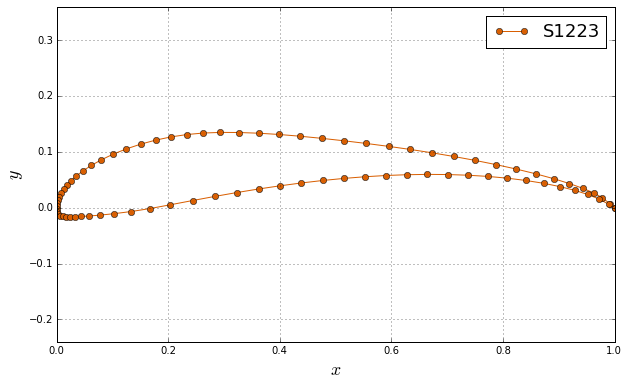

In [10]:
# read and plot S1123 airfoil
name, x, y = read_coordinates('./airfoils/S1223.dat')
plot_airfoil(x, y, name=name)

### References

* Anderson, J.D. "Fundamentals of Aerodynamics." McGraw-Hill, Boston, Massachussets, 2001.
* Drela, M. "XFOIL: An analysis and design system for low Reynolds number airfoils." Low Reynolds number aerodynamics. Springer Berlin Heidelberg, 1989. 1-12.
* Drela, M, and Michael B.G. "Viscous-inviscid analysis of transonic and low Reynolds number airfoils." AIAA journal 25.10 (1987): 1347-1355.
* Gregory, N. and O'Reilly, C.L. "Low-Speed Aerodynamics Characteristics of NACA 0012 Aerofoil Section, including the Effects of Upper-Surface Roughness Simulating Hoar Frost." Reports and Memoranda, No. 3726 (January 1970).
* Palmer, Colin, and Gareth Dyke. "Constraints on the wing morphology of pterosaurs." Proceedings of the Royal Society B: Biological Sciences, 279: 1218-1224, 2011.
* Witton, M.P and Naish, D. "A Reappraisal of Azhdarchid Pterosaur FUnctional Morphology and Paleoecology." PLoS ONE 3(5):e2271, 2008.
* Witton, M.P. "A new approach to determining pterosaur body mass and its implications for pterosaur flight." Zitteliana (2008): 143-158.